# **Importing Libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# <font color=red> **Packet Detection**

## **Loading the Data**

**<font color="Orange">Dataset Link:** https://www.kaggle.com/datasets/advaitnmenon/network-traffic-data-malicious-activity-detection/data

In [6]:
data = pd.read_csv("datasets\\NandakumarMenonAdvait_MT_S2.csv")

In [7]:
data.head()

,Time,Source,Destination,Protocol,Length,Source Port,Destination Port,bad_packet
0,0.000000,VMware_8a:60:5f,Broadcast,ARP,60,NaN,NaN,0
1,0.081233,VMware_8a:12:84,Broadcast,ARP,60,NaN,NaN,0
2,0.217863,VMware_8a:7e:e9,Broadcast,ARP,60,NaN,NaN,0
3,0.419426,VMware_8a:b2:34,Broadcast,ARP,60,NaN,NaN,0
4,0.559886,VMware_8a:4e:1c,Broadcast,ARP,60,NaN,NaN,0


## **EDA**

In [86]:
data.isna().sum()

Time                      0
Source                    0
Destination               0
Protocol                  0
Length                    0
Source Port         1046067
Destination Port    1046067
bad_packet                0
dtype: int64

In [87]:
data.duplicated().sum()

0

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time              1048575 non-null  float64
 1   Source            1048575 non-null  object 
 2   Destination       1048575 non-null  object 
 3   Protocol          1048575 non-null  object 
 4   Length            1048575 non-null  int64  
 5   Source Port       2508 non-null     float64
 6   Destination Port  2508 non-null     float64
 7   bad_packet        1048575 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 64.0+ MB


In [89]:
data.bad_packet.value_counts()

bad_packet
1    1045093
0       3482
Name: count, dtype: int64

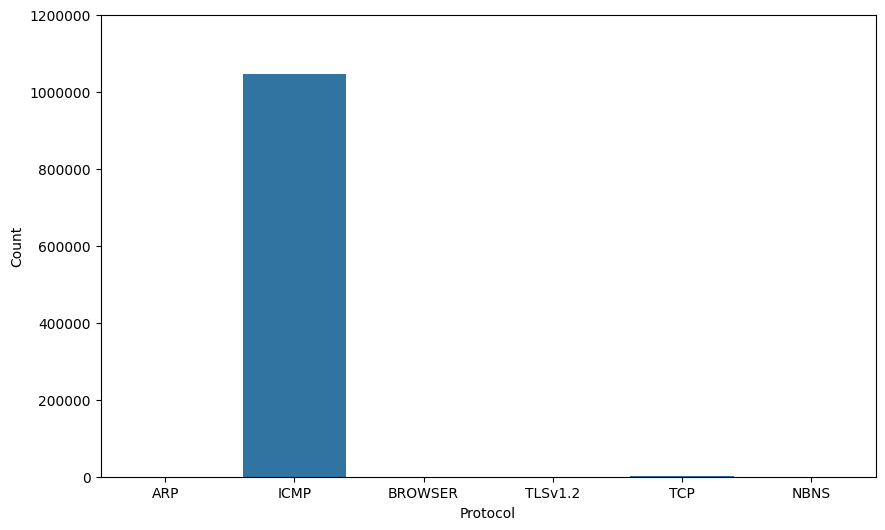

In [16]:
plt.figure(figsize=(10,6))
sns.countplot(x='Protocol',data=data)
plt.xlabel('Protocol')
plt.yticks(plt.yticks()[0], [int(tick) for tick in plt.yticks()[0]])
plt.ylabel('Count')
plt.show()

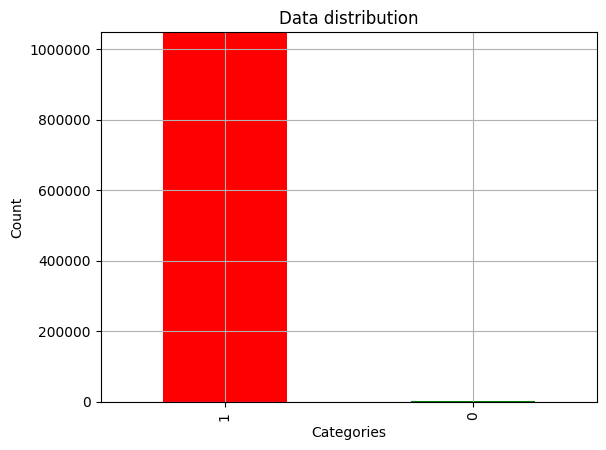

In [14]:
data['bad_packet'].value_counts().plot(kind='bar',color=['r','g'])
plt.xlabel("Categories")
plt.ylabel("Count")
plt.title("Data distribution")
plt.yticks(plt.yticks()[0], [int(tick) for tick in plt.yticks()[0]])
plt.grid()
plt.ylim(0,data.shape[0])
plt.show()

## **Data Pre-Processing**

### **Removing the columns with null values**

In [93]:
data.drop(["Source Port", "Destination Port", "Time"], axis =1, inplace = True)

### **Ranging the IPs**

In [94]:
top_ips = data['Source'].value_counts().index[:4]
data['Source'] = np.where(data['Source'].isin(top_ips), data['Source'], 'Other')

print(data['Source'].value_counts())

Source
192.167.5.35      1045868
192.232.16.204       1590
192.167.5.22          786
Other                 234
142.251.32.14          97
Name: count, dtype: int64


In [95]:
top_dest_ips = data['Destination'].value_counts().index[:6]
data['Destination'] = np.where(data['Destination'].isin(top_dest_ips), data['Destination'], 'Other')

print(data['Destination'].value_counts())

Destination
192.167.5.22       1045117
192.167.5.35          2473
192.232.16.204         699
Broadcast              158
192.167.255.255         70
142.251.32.14           52
Other                    6
Name: count, dtype: int64


### **Label Encoding**

In [96]:
data['Source'] = data['Source'].map({
    '192.167.5.35' : 1,
    '192.232.16.204' : 2,
    '192.167.5.22' : 3,
    '142.251.32.14' : 4,
    'Other' : 5
})

In [97]:
data['Destination'] = data['Destination'].map({
    '192.167.5.22' : 1,
    '192.167.5.35' : 2,
    '192.232.16.204' : 3,
    'Broadcast'  : 4,
    '192.167.255.255' : 5,
    '142.251.32.14' : 6,
    'Other' : 7
})

In [98]:
data['Protocol'] = data['Protocol'].map({
    'ARP' : 1,
    'BROWSER' : 2,
    'ICMP' : 3,
    'NBNS' : 4,
    'TCP' : 5,
    'TLSv1.2' : 6
})

### **Splitting the dataset into Features and Target**

In [99]:
X = data.drop(['bad_packet'], axis = 1)
y = data.bad_packet

### **Splitting into train/test sets**

In [100]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

### **Over Sampling**

<Axes: xlabel='bad_packet'>

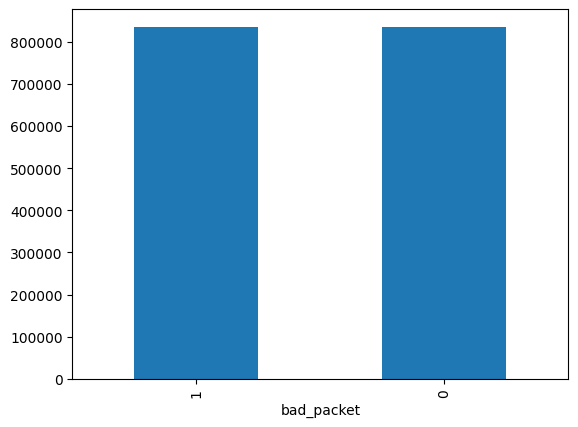

In [101]:
sm = SMOTE(random_state=42)

x_train_res,y_train_res=sm.fit_resample(x_train,y_train)
y_train_res.value_counts().plot(kind='bar')

In [102]:
data.corr()

,Source,Destination,Protocol,Length,bad_packet
Source,1.000000,0.707472,0.269150,0.426173,-0.768647
Destination,0.707472,1.000000,0.587758,0.449248,-0.863146
Protocol,0.269150,0.587758,1.000000,0.786226,-0.752979
Length,0.426173,0.449248,0.786226,1.000000,-0.690807
bad_packet,-0.768647,-0.863146,-0.752979,-0.690807,1.000000


## **Model Building**

In [103]:
RF = RandomForestClassifier(random_state=42)

# Training the model
RF.fit(x_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [104]:
# Making predictions on the test set
y_pred_rf = RF.predict(x_test)

In [105]:
# Evaluating the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
classification_rep_rf = classification_report(y_test, y_pred_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

In [106]:
# Printing the results
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Classification Report:\n{classification_rep_rf}")
print(f"Confusion Matrix:\n{cm_rf}")

Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       696
           1       1.00      1.00      1.00    209019

    accuracy                           1.00    209715
   macro avg       1.00      1.00      1.00    209715
weighted avg       1.00      1.00      1.00    209715

Confusion Matrix:
[[   696      0]
 [     0 209019]]


## **Saving the model**

In [107]:
pickle.dump(RF, open('WebApp/models/packet_detection.pkl', 'wb'))

# <font color=red> **URL detection**

## **Loading Dataset**

**<font color="Orange">Dataset Link:** https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data

In [3]:
url_data = pd.read_csv("datasets\malicious_phish.csv")
url_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [4]:
url_data.type.value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [214]:
url_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


## **Data Cleaning & EDA**

### **Checking different classes**

In [215]:
print(url_data['type'].unique())

['phishing' 'benign' 'defacement' 'malware']


In [216]:
url_data["type"].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='type'>

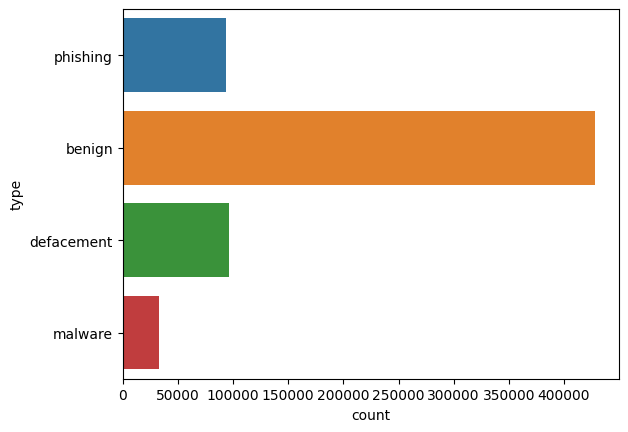

In [217]:
sns.countplot(data=url_data, y='type', hue='type')

### **checking null values**

In [218]:
url_data.isna().sum()

url     0
type    0
dtype: int64

### **checking duplicate values**

In [219]:
url_data.duplicated().sum()

10066

### **Removing duplicate Values**

In [220]:
url_data.drop_duplicates(keep=False, inplace=True)
url_data.duplicated().sum()

0

### **wordcloud**

In [221]:
df_bengin = url_data[url_data['type'] == 'benign']
df_malware = url_data[url_data['type'] == 'malware']
df_defacement = url_data[url_data['type'] == 'defacement']
df_phishing = url_data[url_data['type'] == 'phishing']

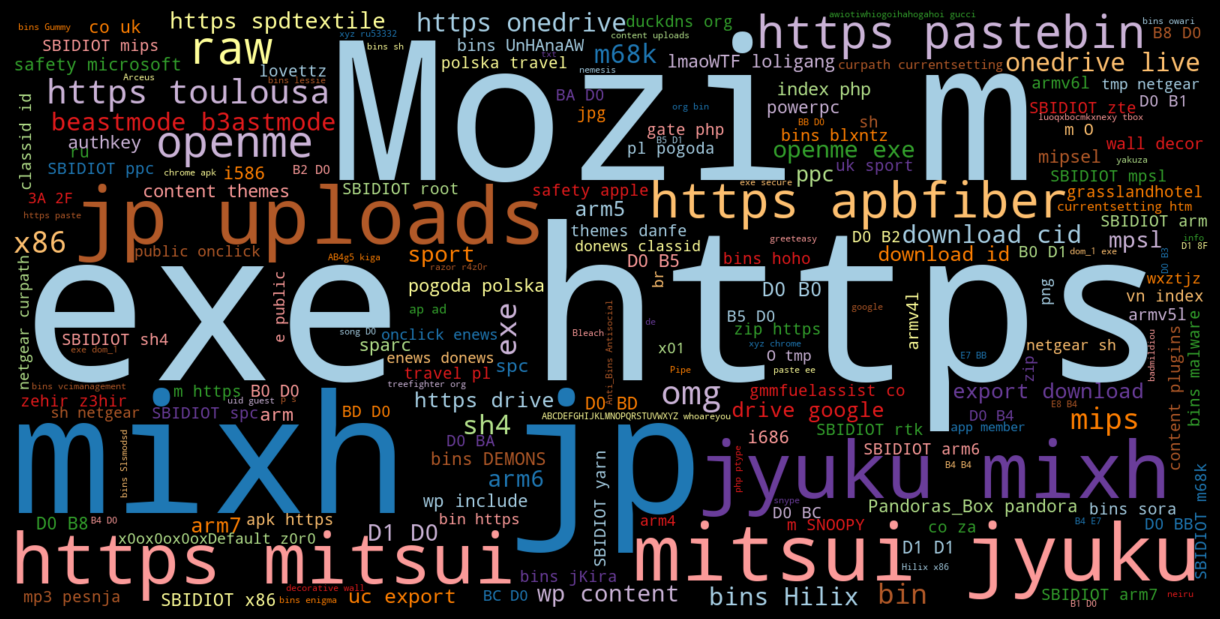

In [222]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

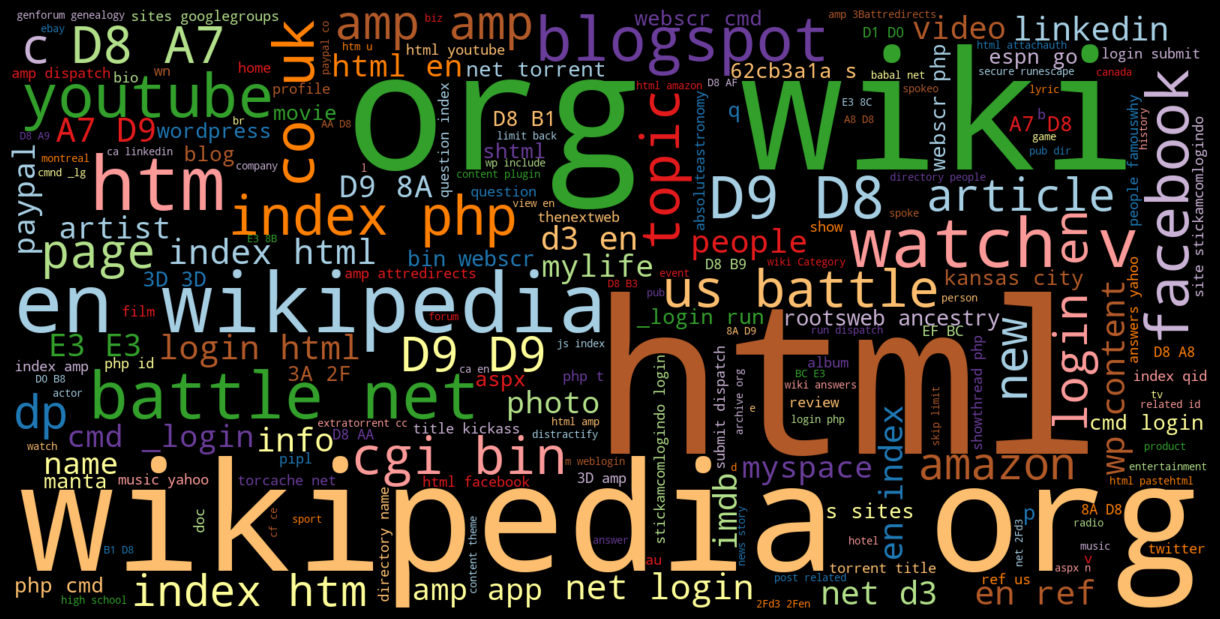

In [223]:
benign_url = " ".join(i for i in df_bengin.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

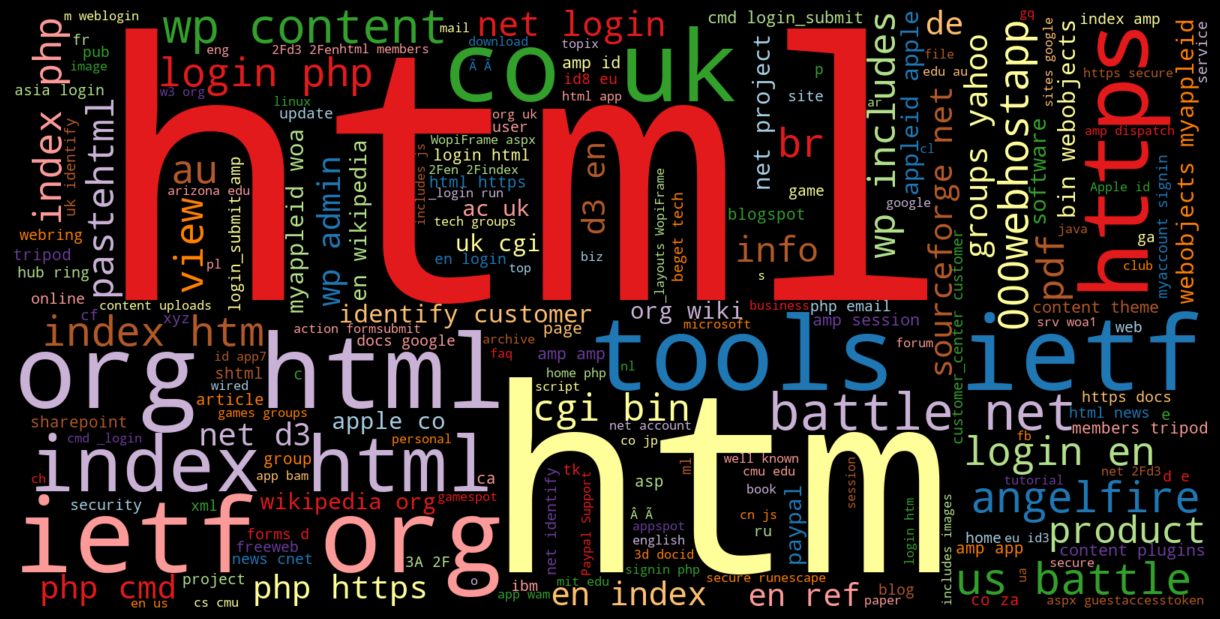

In [224]:
phishing_url = " ".join(i for i in df_phishing.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(phishing_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

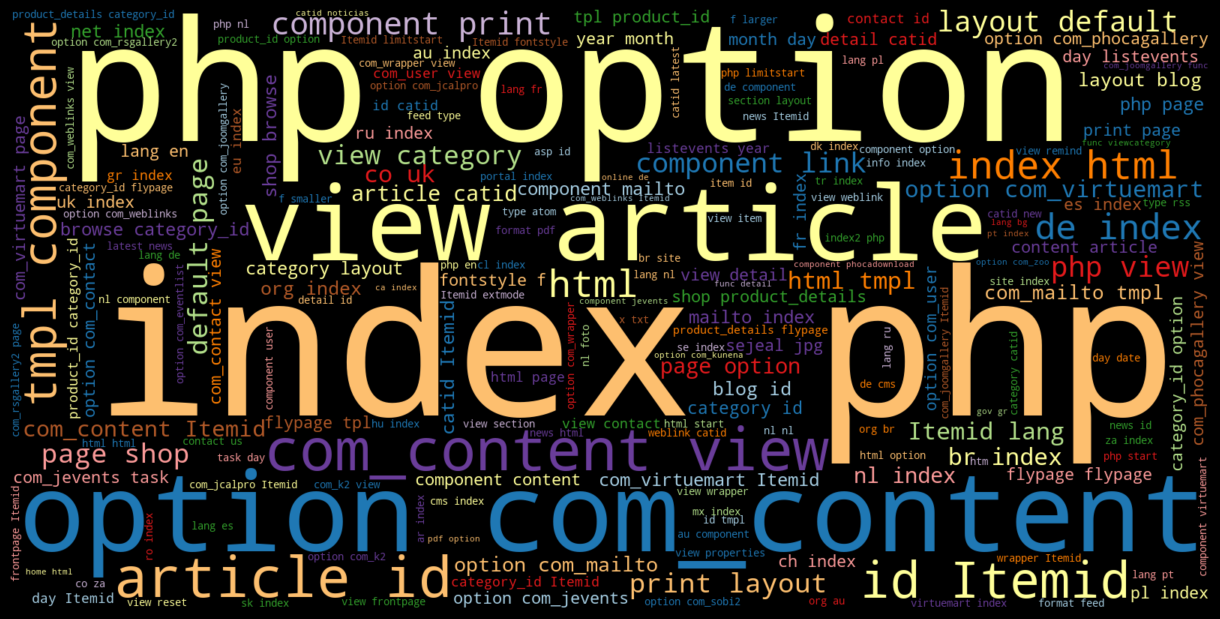

In [225]:
defacement_url = " ".join(i for i in df_defacement.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired').generate(defacement_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## **Splitting the data**

### **Features and Target split**

In [226]:
url_X = url_data.url
url_y = url_data.type

### **Train-Validate-Test split**

In [227]:
# First, get 80% train and 20% test split.
url_X_train, url_X_test, url_y_train, url_y_test = train_test_split(url_X, url_y, stratify=url_y, test_size=0.2,shuffle=True, random_state=42)

# Second, get 80% train_1 for training and 20% val for validation with epochs
url_x_train_1, url_X_val, url_y_train_1, url_y_val = train_test_split(url_X_train, url_y_train, stratify=url_y_train, test_size=0.2,shuffle=True, random_state=42)

## **Model Building using pipeline**

In [228]:
pipe=Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,5),max_df=0.95, max_features=1000)),
        ('clf',LogisticRegression())
    ]
)

In [229]:
pipe.fit(url_x_train_1, url_y_train_1)

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=1000,
                                 ngram_range=(1, 5))),
                ('clf', LogisticRegression())])

In [230]:
url_y_pred = pipe.predict(url_X_test)

In [231]:
cm = confusion_matrix(url_y_test, url_y_pred)
cm

array([[83363,   342,    42,  1865],
       [  320, 18082,    56,   459],
       [  298,    58,  3894,   191],
       [ 7344,   564,   104, 10803]], dtype=int64)

In [232]:
cr = classification_report(url_y_test, url_y_pred)
print(cr)

              precision    recall  f1-score   support

      benign       0.91      0.97      0.94     85612
  defacement       0.95      0.96      0.95     18917
     malware       0.95      0.88      0.91      4441
    phishing       0.81      0.57      0.67     18815

    accuracy                           0.91    127785
   macro avg       0.91      0.85      0.87    127785
weighted avg       0.90      0.91      0.90    127785



## **Saving the model**

In [234]:
# pickle.dump(pipe, open('WebApp\\models\\url_detection.pkl', 'wb'))

# <font color=red> **Email HAM/SPAM**

## **Loading the data**

**<font color="Orange">Dataset Link:** https://www.kaggle.com/datasets/purusinghvi/email-spam-classification-dataset

In [17]:
mail_data = pd.read_csv(r"C:\\Users\\HP\\Documents\\PRACTICE\\Integrated_threat_detection\\datasets\\email_spam.csv",encoding='latin1')

In [18]:
mail_data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## **EDA**

In [105]:
mail_data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis =1, inplace=True )

In [19]:
mail_data.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [107]:
mail_data.duplicated().sum()

403

In [108]:
mail_data.drop_duplicates(keep=False,inplace=True)

In [110]:
mail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4888 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      4888 non-null   object
 1   v2      4888 non-null   object
dtypes: object(2)
memory usage: 114.6+ KB


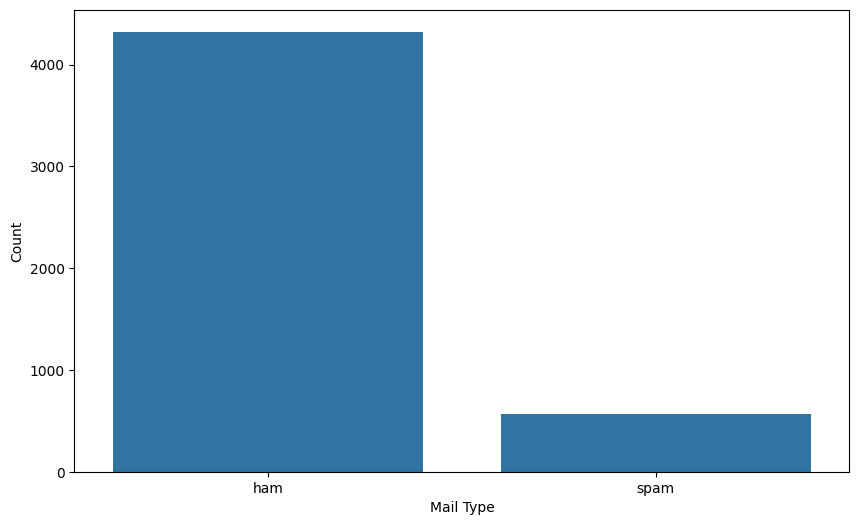

In [111]:
plt.figure(figsize=(10,6))
sns.countplot(x='v1',data=mail_data)
plt.xlabel('Mail Type')
plt.ylabel('Count')
plt.show()

### **Wordcloud**

In [112]:
df_ham = mail_data[mail_data['v1'] == 'ham']
df_spam = mail_data[mail_data['v1'] == 'spam']

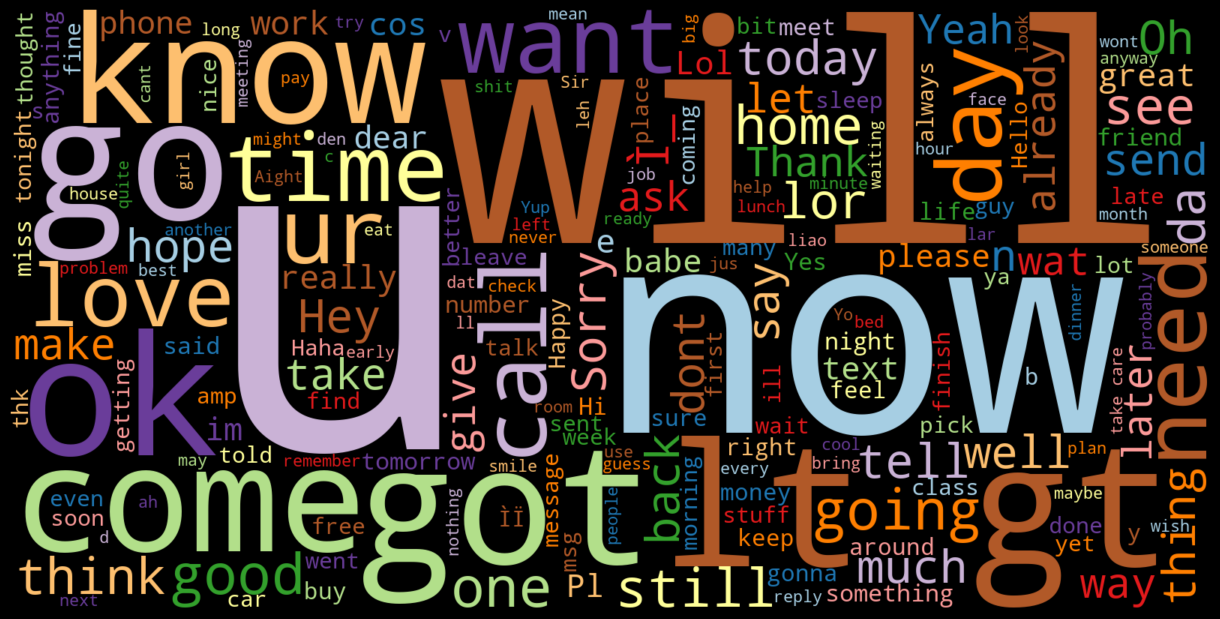

In [113]:
Ham = " ".join(i for i in df_ham.v2)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(Ham)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

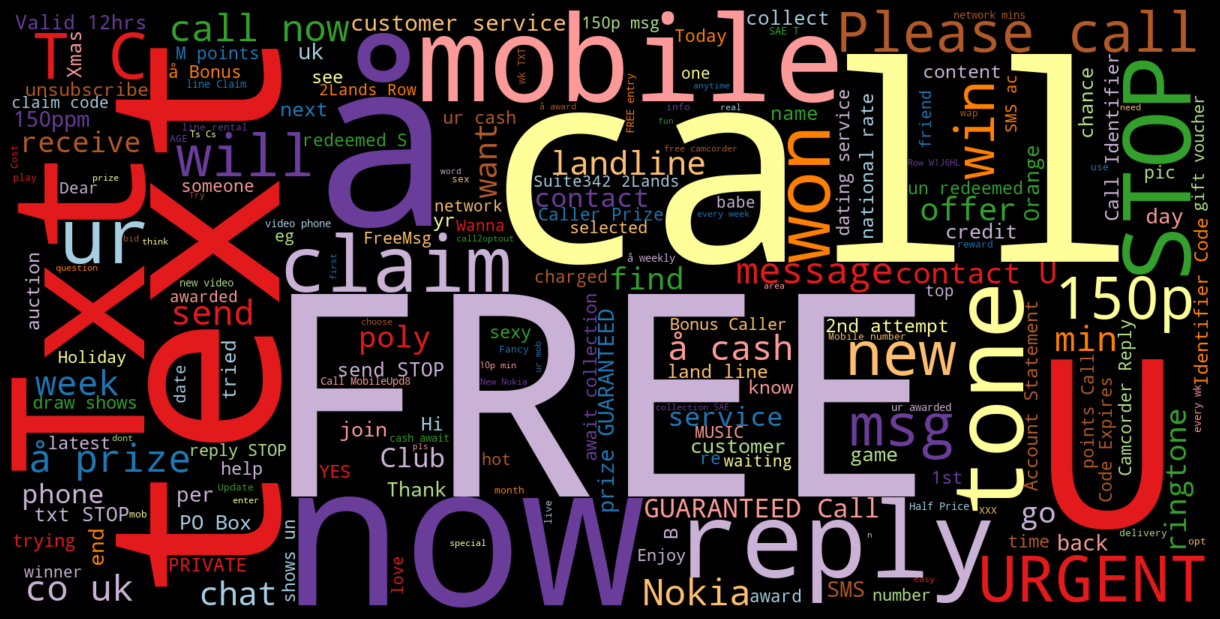

In [114]:
Spam = " ".join(i for i in df_spam.v2)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(Spam)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## **Splitting of Dataset**

### **Feature/Target Split**

In [115]:
X_mail = mail_data.v2
y_mail = mail_data.v1

In [116]:
lb = LabelEncoder()

y_mail = lb.fit_transform(y_mail)

### **Train/Test Split**

In [117]:
mail_x_train, mail_x_test, mail_y_train, mail_y_test = train_test_split(X_mail, y_mail, stratify=y_mail, test_size=0.2,shuffle=True, random_state=42)

## **Model Building using pipeline**

In [118]:
mail_pipe = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,5),max_df=0.95, max_features=100)),
        ('xgb',XGBClassifier())
    ]
)

In [119]:
mail_pipe.fit(mail_x_train,mail_y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=100,
                                 ngram_range=(1, 5))),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [120]:
mail_y_pred = mail_pipe.predict(mail_x_test)

In [121]:
mail_cm = confusion_matrix(mail_y_test, mail_y_pred)
mail_cm

array([[862,   3],
       [ 25,  88]], dtype=int64)

In [186]:
mail_cr = classification_report(mail_y_test, mail_y_pred)
print(mail_cr)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       865
           1       0.97      0.78      0.86       113

    accuracy                           0.97       978
   macro avg       0.97      0.89      0.92       978
weighted avg       0.97      0.97      0.97       978



## **Saving the model**

In [189]:
# pickle.dump(mail_pipe, open('WebApp\models\mail_detection.pkl', 'wb'))